# Fine-tune `roberta-base` model

In this notebook, we will fine-tune [the `roberta-base` model][1], so that it can represent math-specific tokens.

 [1]: https://huggingface.co/roberta-base

In [1]:
! hostname

docker.apollo.fi.muni.cz


In [2]:
%%capture
! pip install .[transformers,evaluation]

In [3]:
%%capture
! make tuned-roberta-base-text+latex

We will push the fine-tuned `roberta-base` model to [the 🤗 Model Hub][1].

 [1]: https://huggingface.co/witiko/mathberta

In [4]:
from transformers import AutoModel

model = AutoModel.from_pretrained('./tuned-roberta-base-text+latex/MaskedLanguageModeling/')
model.push_to_hub('mathberta')

## Intrinsic evaluation

To validate our model during the training, we will plot the validation loss.

### In-domain evaluation

To see how well our model generalizes to unseen data from our target domain (scientific texts), we use a held-out dataset.

In [5]:
%ls -lh dataset-text+latex.txt  # this is the training dataset

-rw-r--r-- 1 1008 1011 52G May  5 01:52 dataset-text+latex.txt


In [6]:
%ls -lh dataset-text+latex-validation.txt  # this is the validation dataset

-rw-r--r-- 1 1008 1011 457M May  5 22:11 dataset-text+latex-validation.txt


In [7]:
from collections import defaultdict
import json
from pathlib import Path
from statistics import mean
from typing import List, Tuple

def get_checkpoint_step(input_checkpoint_directory: Path) -> int:
    _, checkpoint_step = input_checkpoint_directory.name.split('-')
    checkpoint_step = int(checkpoint_step)
    return checkpoint_step

checkpoints = Path('tuned-roberta-base-text+latex.MLM-objective').glob('*/')
latest_checkpoint = max(checkpoints, key=get_checkpoint_step)
with (latest_checkpoint / 'trainer_state.json').open('rt') as f:
    id_trainer_state = json.load(f)

learning_rates = defaultdict(lambda: list())
id_train_losses = defaultdict(lambda: list())
id_validation_losses = defaultdict(lambda: list())

for log in id_trainer_state['log_history']:
    epoch = float(log['epoch'])
    if 'learning_rate' in log:
        learning_rate = float(log['learning_rate'])
        learning_rates[epoch].append(learning_rate)
    if 'loss' in log:
        loss = float(log['loss'])
        id_train_losses[epoch].append(loss)
    if 'eval_loss' in log:
        eval_loss = float(log['eval_loss'])
        id_validation_losses[epoch].append(eval_loss)

def average_values(item: Tuple[float, List[float]]) -> Tuple[float, float]:
    epoch, values = item
    average_value = mean(values)
    return (epoch, average_value)

learning_rates = sorted(map(average_values, learning_rates.items()))
id_train_losses = sorted(map(average_values, id_train_losses.items()))
id_validation_losses = sorted(map(average_values, id_validation_losses.items()))

### Out-of-domain evaluation

To see how well our model generalizes to unseen data from a different domain, we use [a dataset of English texts from the European Constitution][1].

 [1]: https://opus.nlpl.eu/EUconst.php

In [8]:
%%capture
! make out-of-domain-dataset-text-validation.json

In [9]:
%ls -lh out-of-domain-dataset-text-validation.txt

-rw-r--r-- 1 1008 1011 952K May 25 23:28 out-of-domain-dataset-text-validation.txt


In [10]:
%%capture
! make out-of-domain-dataset-text-validation.json

In [11]:
%ls -lh out-of-domain-dataset-text-validation.json

-rw-r--r-- 1 1008 1011 12K Jun 11 21:01 out-of-domain-dataset-text-validation.json


In [12]:
with open('out-of-domain-dataset-text-validation.json', 'rt') as f:
    ood_results = json.load(f)

ood_validation_losses = defaultdict(lambda: list())

for ood_result in ood_results:
    epoch = ood_result['epoch']
    loss = ood_result['loss']
    ood_validation_losses[epoch].append(loss)

ood_validation_losses = sorted(map(average_values, ood_validation_losses.items()))

### Results

We will use the matplotlib library to plot the evaluation results.

In [13]:
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.rc('legend', fontsize=16)

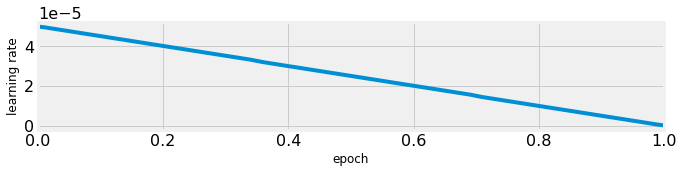

In [14]:
plt.figure(figsize=(10, 2))
plt.plot(*zip(*learning_rates), label='learning rate')
plt.xlabel('epoch')
plt.xlim((0.0, epoch))
_ = plt.ylabel('learning rate')

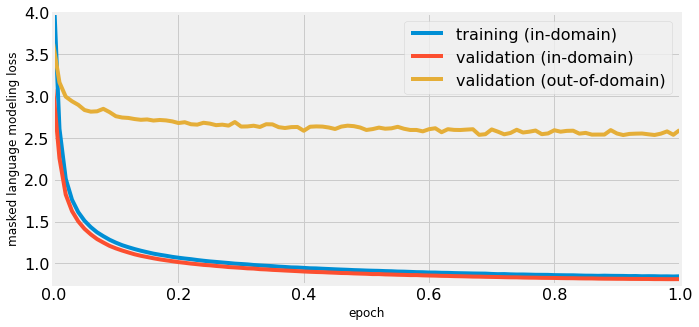

In [15]:
plt.figure(figsize=(10, 5))
plt.plot(*zip(*id_train_losses), label='training (in-domain)')
plt.plot(*zip(*id_validation_losses), label='validation (in-domain)')
plt.plot(*zip(*ood_validation_losses), label='validation (out-of-domain)')
plt.xlabel('epoch')
plt.ylabel('masked language modeling loss')
plt.xlim((0.0, epoch))
plt.ylim((0.75, 4.0))
plt.legend()
plt.savefig('paper/learning-curves.pdf', dpi=600)